In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import library
from re import escape
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql.functions import count
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as FD
import numpy as np
from scipy.stats import f_oneway
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

In [ ]:
#Mount Gdrive to load data
df=pd.DataFrame(pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Big data/ProjectBigdata/loan_data.csv"))
df.head(10)

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
0,1,credit_card,0.143,498.35,150000.0,15.70,694,37865,19748,0.674,3,5.0,0,0
1,1,home_improvement,0.110,870.29,55000.0,30.13,734,35947,11898,0.476,2,1.0,0,0
2,1,credit_card,0.088,785.32,165000.0,16.11,694,36373,20681,0.567,0,0.0,0,0
3,1,credit_card,0.170,285.03,40000.0,32.07,744,40269,8514,0.226,2,0.0,0,0
4,1,debt_consolidation,0.088,570.81,36000.0,23.73,714,38565,7555,0.256,1,0.0,0,1
5,1,debt_consolidation,0.170,893.73,115000.0,28.58,679,37803,60984,0.956,0,0.0,0,1
6,1,credit_card,0.143,281.09,95000.0,18.51,749,36008,14083,0.156,0,0.0,0,1
7,1,debt_consolidation,0.110,435.05,20160.0,123.93,774,41365,353,0.007,1,0.0,0,1
8,1,debt_consolidation,0.088,1268.46,130000.0,20.09,704,37469,29208,0.507,0,0.0,0,1
9,1,debt_consolidation,0.161,365.73,30000.0,37.28,734,35490,13869,0.431,0,0.0,0,1


#Phân tích dữ liệu cơ bản

In [ ]:
# Initialize SparkSession
spark = SparkSession \
        .builder \
        .appName("Python Spark create RDD") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

In [ ]:
# Read the CSV file
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Big data/ProjectBigdata/loan_data.csv", header=True, escape="\"")
# Show the first 5 rows
df.show(5)

+-------------+------------------+--------+-----------+--------------+-----+----+-----------------+---------+----------+--------------+-----------+-------+--------------+
|credit_policy|           purpose|int_rate|installment|log_annual_inc|  dti|fico|days_with_cr_line|revol_bal|revol_util|inq_last_6mths|delinq_2yrs|pub_rec|not_fully_paid|
+-------------+------------------+--------+-----------+--------------+-----+----+-----------------+---------+----------+--------------+-----------+-------+--------------+
|            1|       credit_card|   0.143|     498.35|        150000| 15.7| 694|            37865|    19748|     0.674|             3|          5|      0|             0|
|            1|  home_improvement|    0.11|     870.29|         55000|30.13| 734|            35947|    11898|     0.476|             2|          1|      0|             0|
|            1|       credit_card|   0.088|     785.32|        165000|16.11| 694|            36373|    20681|     0.567|             0|          

In [ ]:
df.printSchema()

root
 |-- credit_policy: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- log_annual_inc: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- fico: string (nullable = true)
 |-- days_with_cr_line: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- not_fully_paid: string (nullable = true)



In [ ]:
df.dtypes

[('credit_policy', 'string'),
 ('purpose', 'string'),
 ('int_rate', 'string'),
 ('installment', 'string'),
 ('log_annual_inc', 'string'),
 ('dti', 'string'),
 ('fico', 'string'),
 ('days_with_cr_line', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('inq_last_6mths', 'string'),
 ('delinq_2yrs', 'string'),
 ('pub_rec', 'string'),
 ('not_fully_paid', 'string')]

#EDA

In [ ]:
#Điếm xem có bao nhiêu dòng dữ liệu
df.count()

37066

In [ ]:
# Count the number of null or NaN values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------------+-------+--------+-----------+--------------+---+----+-----------------+---------+----------+--------------+-----------+-------+--------------+
|credit_policy|purpose|int_rate|installment|log_annual_inc|dti|fico|days_with_cr_line|revol_bal|revol_util|inq_last_6mths|delinq_2yrs|pub_rec|not_fully_paid|
+-------------+-------+--------+-----------+--------------+---+----+-----------------+---------+----------+--------------+-----------+-------+--------------+
|            0|      0|       0|          0|             0|100|   0|                0|        0|        12|             0|         34|      0|             0|
+-------------+-------+--------+-----------+--------------+---+----+-----------------+---------+----------+--------------+-----------+-------+--------------+



In [ ]:
#Drop all Nan rows
df=df.dropna()
df.show(5)

+-------------+------------------+--------+-----------+--------------+-----+----+-----------------+---------+----------+--------------+-----------+-------+--------------+
|credit_policy|           purpose|int_rate|installment|log_annual_inc|  dti|fico|days_with_cr_line|revol_bal|revol_util|inq_last_6mths|delinq_2yrs|pub_rec|not_fully_paid|
+-------------+------------------+--------+-----------+--------------+-----+----+-----------------+---------+----------+--------------+-----------+-------+--------------+
|            1|       credit_card|   0.143|     498.35|        150000| 15.7| 694|            37865|    19748|     0.674|             3|          5|      0|             0|
|            1|  home_improvement|    0.11|     870.29|         55000|30.13| 734|            35947|    11898|     0.476|             2|          1|      0|             0|
|            1|       credit_card|   0.088|     785.32|        165000|16.11| 694|            36373|    20681|     0.567|             0|          

+--------------+-----+
|not_fully_paid|count|
+--------------+-----+
|             0|10145|
|             1|26775|
+--------------+-----+



<Axes: xlabel='not_fully_paid'>

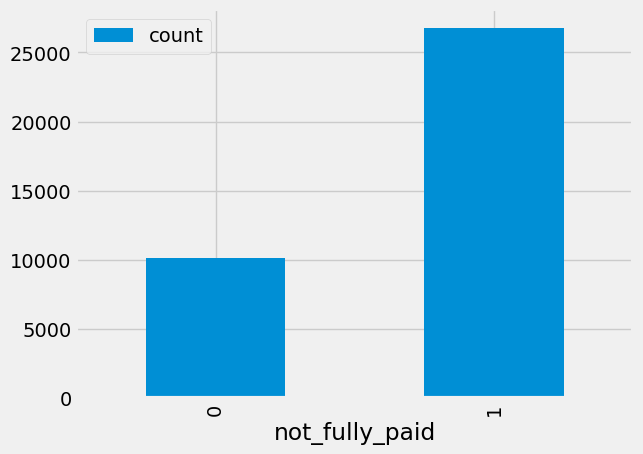

In [ ]:
#Thống kê khoản vay có hoàn trả hay không
#0:Khoản vay không trả đầy đủ
#1:Khoản vay được trả đầy đủ
# Group by 'not_fully_paid' and count occurrences
result_df = df.groupBy('not_fully_paid').count()

# Show the results
result_df.show()

# For plotting, you'll need to convert to Pandas DataFrame
result_pd = result_df.toPandas()
result_pd.plot(x='not_fully_paid', y='count', kind='bar')

In [ ]:
from pyspark.sql import functions as F
# get mean value of column
mean = df.select(F.mean(df['not_fully_paid'])).collect()[0][0]
mean

0.725216684723727

Imbalanced data ==> Trước khi train

#Pre-procesing data

In [ ]:
#Tìm các field là Object/String
object_cols = [i for i in df.columns if dict(df.dtypes)[i] == 'string']
print(object_cols)

['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid']


In [ ]:
# Group by 'not_fully_paid' and count occurrences
result_df = df.groupBy('purpose').agg(count('*').alias('count'))

# Show the results
result_df.show()

+------------------+-----+
|           purpose|count|
+------------------+-----+
|             other| 2496|
|    small_business|  269|
|debt_consolidation|19516|
|       credit_card| 9087|
|            moving|  234|
|          vacation|  313|
|  renewable_energy|   15|
|             house|  406|
|               car|  384|
|    major_purchase|  899|
|           medical|  465|
|  home_improvement| 2836|
+------------------+-----+



In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def process_purpose(x):
  if x=='debt_consolidation':
    return 1
  else:
    return 0

# Convert Python function to PySpark UDF
process_purpose_udf = udf(process_purpose, IntegerType())
# Apply the UDF to the 'purpose' column
df = df.withColumn('purpose_int', process_purpose_udf(df['purpose']))

In [ ]:
# Group by 'not_fully_paid' and count occurrences
result_df = df.groupBy('purpose_int').agg(count('*').alias('count'))

# Show the results
result_df.show()

+-----------+-----+
|purpose_int|count|
+-----------+-----+
|          1|19516|
|          0|17404|
+-----------+-----+



In [ ]:
#Drop purpose and view lại
df=df.drop('purpose','credit_policy')
df.show(5)

+--------+-----------+--------------+-----+----+-----------------+---------+----------+--------------+-----------+-------+--------------+-----------+
|int_rate|installment|log_annual_inc|  dti|fico|days_with_cr_line|revol_bal|revol_util|inq_last_6mths|delinq_2yrs|pub_rec|not_fully_paid|purpose_int|
+--------+-----------+--------------+-----+----+-----------------+---------+----------+--------------+-----------+-------+--------------+-----------+
|   0.143|     498.35|        150000| 15.7| 694|            37865|    19748|     0.674|             3|          5|      0|             0|          0|
|    0.11|     870.29|         55000|30.13| 734|            35947|    11898|     0.476|             2|          1|      0|             0|          0|
|   0.088|     785.32|        165000|16.11| 694|            36373|    20681|     0.567|             0|          0|      0|             0|          0|
|    0.17|     285.03|         40000|32.07| 744|            40269|     8514|     0.226|             

In [ ]:
# Chuyển đổi các cột số từ kiểu chuỗi sang kiểu số
for col in object_cols:
    if col not in df.columns: # Check if column exists
        print(f"Cột {col} không tồn tại trong DataFrame.")
        continue
    try:
        # Cố gắng chuyển đổi sang kiểu Double trước
        df = df.withColumn(col, df[col].cast('double')) #Use df instead of spark_df
        print(f"Đã chuyển đổi cột {col} sang kiểu DoubleType.")
    except:
        # Nếu không được, chuyển đổi sang kiểu Integer
        df = df.withColumn(col, df[col].cast('int')) #Use df instead of spark_df
        print(f"Đã chuyển đổi cột {col} sang kiểu IntegerType.")

# Hiển thị DataFrame kết quả sau khi chuyển đổi
df.show() #Use df instead of spark_df

Cột credit_policy không tồn tại trong DataFrame.
Cột purpose không tồn tại trong DataFrame.
Đã chuyển đổi cột int_rate sang kiểu DoubleType.
Đã chuyển đổi cột installment sang kiểu DoubleType.
Đã chuyển đổi cột log_annual_inc sang kiểu DoubleType.
Đã chuyển đổi cột dti sang kiểu DoubleType.
Đã chuyển đổi cột fico sang kiểu DoubleType.
Đã chuyển đổi cột days_with_cr_line sang kiểu DoubleType.
Đã chuyển đổi cột revol_bal sang kiểu DoubleType.
Đã chuyển đổi cột revol_util sang kiểu DoubleType.
Đã chuyển đổi cột inq_last_6mths sang kiểu DoubleType.
Đã chuyển đổi cột delinq_2yrs sang kiểu DoubleType.
Đã chuyển đổi cột pub_rec sang kiểu DoubleType.
Đã chuyển đổi cột not_fully_paid sang kiểu DoubleType.
+--------+-----------+--------------+------+-----+-----------------+---------+----------+--------------+-----------+-------+--------------+-----------+
|int_rate|installment|log_annual_inc|   dti| fico|days_with_cr_line|revol_bal|revol_util|inq_last_6mths|delinq_2yrs|pub_rec|not_fully_paid|pur

In [ ]:
df.dtypes

[('int_rate', 'double'),
 ('installment', 'double'),
 ('log_annual_inc', 'double'),
 ('dti', 'double'),
 ('fico', 'double'),
 ('days_with_cr_line', 'double'),
 ('revol_bal', 'double'),
 ('revol_util', 'double'),
 ('inq_last_6mths', 'double'),
 ('delinq_2yrs', 'double'),
 ('pub_rec', 'double'),
 ('not_fully_paid', 'double'),
 ('purpose_int', 'int')]

In [ ]:
#Check Corr để xem có bỏ field nào đi không ?
pandas_df = df.toPandas()
corr = pandas_df.corr()
corr.style.background_gradient(cmap='coolwarm')


,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,purpose_int
int_rate,1.000000,0.042739,-0.055919,0.116065,-0.456244,0.086726,0.021824,0.133468,-0.003504,0.172759,0.046075,-0.036599,0.097478
installment,0.042739,1.000000,0.227242,0.084286,0.022387,-0.125390,0.170643,0.028539,0.226005,0.046695,-0.049956,-0.013016,0.140044
log_annual_inc,-0.055919,0.227242,1.000000,-0.121779,0.020853,-0.119594,0.151355,0.044720,0.177392,0.029868,-0.034424,-0.037026,-0.002927
dti,0.116065,0.084286,-0.121779,1.000000,-0.013244,-0.044598,0.077765,0.000342,0.081434,0.032497,-0.010775,-0.031361,0.054696
fico,-0.456244,0.022387,0.020853,-0.013244,1.000000,-0.120728,-0.021722,-0.188516,-0.065700,-0.307689,-0.191167,-0.027124,-0.024893
days_with_cr_line,0.086726,-0.125390,-0.119594,-0.044598,-0.120728,1.000000,-0.066180,-0.068710,-0.187349,-0.052515,-0.006409,-0.038029,-0.006357
revol_bal,0.021824,0.170643,0.151355,0.077765,-0.021722,-0.066180,1.000000,0.128898,-0.203446,-0.146972,-0.067585,-0.356469,0.029699
revol_util,0.133468,0.028539,0.044720,0.000342,-0.188516,-0.068710,0.128898,1.000000,-0.061745,-0.014098,-0.052424,-0.086816,0.004182
inq_last_6mths,-0.003504,0.226005,0.177392,0.081434,-0.065700,-0.187349,-0.203446,-0.061745,1.000000,0.220876,-0.056046,0.219629,-0.007000
delinq_2yrs,0.172759,0.046695,0.029868,0.032497,-0.307689,-0.052515,-0.146972,-0.014098,0.220876,1.000000,-0.030163,0.135084,0.007397


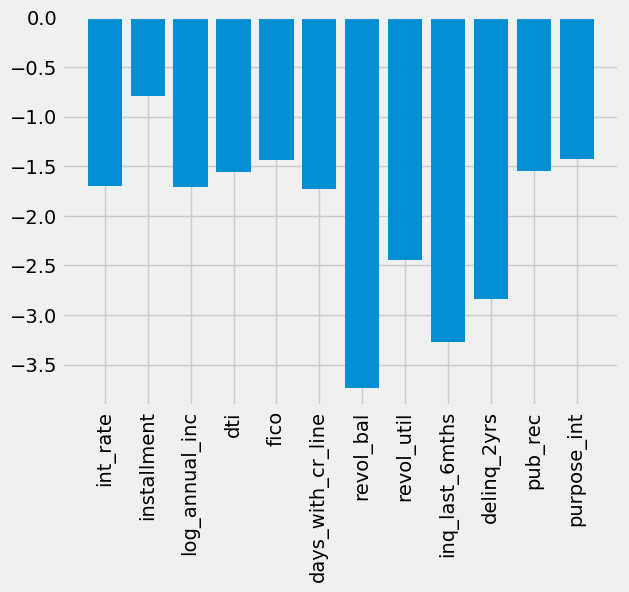

In [ ]:
# Explicitly create a new SparkSession
spark = SparkSession.builder.appName("F_Score_Calculation").getOrCreate()

# Assuming df_loan is a Spark DataFrame
# Define predictors and label
predictors = df.columns
predictors = [col for col in predictors if col != "not_fully_paid"]
# Calculate F-statistics for each feature
f_scores = []
for predictor in predictors:
    # Cast the predictor column to numeric type (e.g., float) before collecting
    groups = df.groupby("not_fully_paid").agg (F.collect_list(F.col(predictor).cast("float")).alias(predictor)).select(predictor).collect()
    group_0 = groups[0][0]
    group_1= groups[1][0]
    # Calculate the F-statistic using scipy's f_oneway function
    f_stat, p_value = f_oneway (group_0, group_1)
    f_scores.append(f_stat)
    # Convert the list of F-statistics to an array
f_scores = np.array(f_scores)
scores =-np.log10(f_scores)
# Plot the scores
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

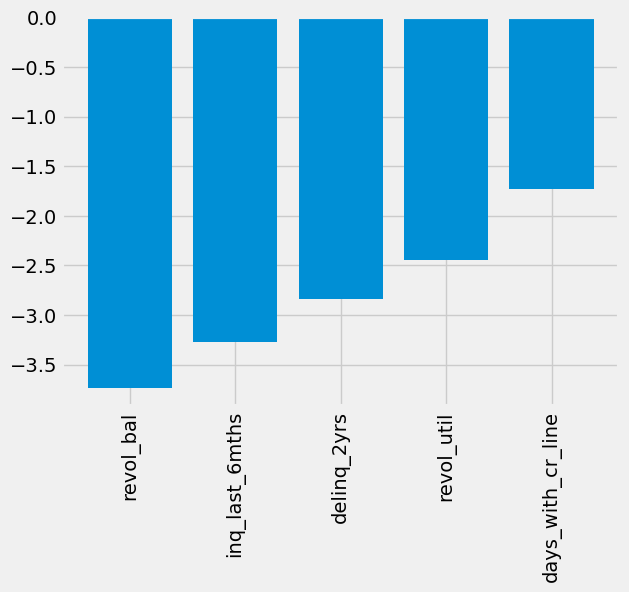

Top k features: ['revol_bal', 'inq_last_6mths', 'delinq_2yrs', 'revol_util', 'days_with_cr_line']


In [ ]:
# Create a list of tuples (feature, score) and sort it by score
feature_scores = list(zip(predictors, f_scores))
sorted_features = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Select the top k features
k = 5
top_features = sorted_features[:k]

# Extract the names of the top k features
top_feature_names = [feature for feature, score in top_features]

# Plot the scores of the top k features
top_scores = [-np.log10(score) for feature, score in top_features]
plt.bar(range(k), top_scores)
plt.xticks(range(k), top_feature_names, rotation='vertical')
plt.show()

print("Top k features:", top_feature_names)


In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
assembler = VectorAssembler(inputCols=top_feature_names, outputCol="features")
df = assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

In [ ]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
X_train = train_df.select("scaledFeatures")
y_train = train_df.select("not_fully_paid")
X_test = test_df.select("scaledFeatures")
y_test = test_df.select("not_fully_paid")


Không có 2 cột input nào quá corr ->Giữ lại toàn bộ input

##Train model  01 -Dùng Logistic Regresion

In [ ]:
# Count the occurrences of each unique value in the 'not_fully_paid' column
y_train = y_train.groupBy("not_fully_paid").agg(count("not_fully_paid").alias("count")).show()

+--------------+-----+
|not_fully_paid|count|
+--------------+-----+
|           0.0| 8130|
|           1.0|21423|
+--------------+-----+



Accuracy: 0.7929
F1 Score: 0.7647
Precision: 0.7873
Recall: 0.7929


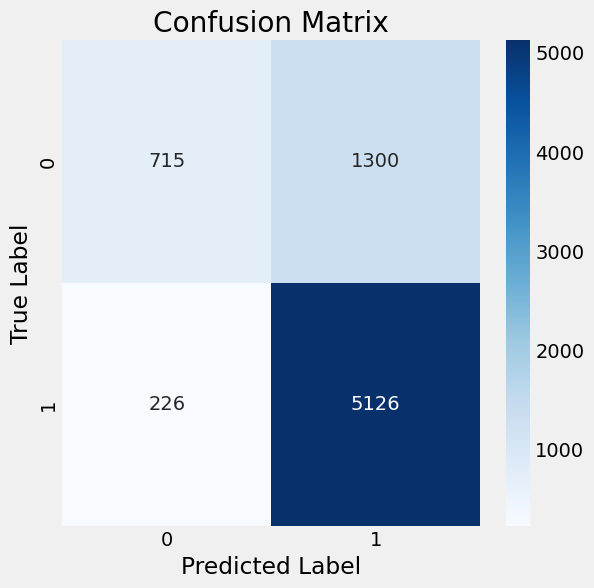

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='not_fully_paid')
model = lr.fit(train_df)
predictions = model.transform(test_df)
# Step 3: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="not_fully_paid", predictionCol="prediction", metricName="accuracy") # Changed labelCol to "not_fully_paid"
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")
# Step 4: Generate classification metrics (precision, recall, F1-score)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="not_fully_paid", predictionCol="prediction", metricName="f1") # Changed labelCol to "not_fully_paid"
evaluator_precision = MulticlassClassificationEvaluator(labelCol="not_fully_paid", predictionCol="prediction", metricName="weightedPrecision") # Changed labelCol to "not_fully_paid"
evaluator_recall = MulticlassClassificationEvaluator(labelCol="not_fully_paid", predictionCol="prediction", metricName="weightedRecall") # Changed labelCol to "not_fully_paid"

f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Step 5: Create a confusion matrix
# Convert predictions and labels to RDD and compute confusion matrix
y_true = predictions.select(col("not_fully_paid")).rdd.flatMap(lambda x: x) # Changed labelCol to "not_fully_paid"
y_pred = predictions.select(col("prediction")).rdd.flatMap(lambda x: x)

cm = y_true.zip(y_pred).map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x + y).collect()
cm_matrix = np.zeros((2, 2))

for (i, j), count in cm:
    cm_matrix[int(i)][int(j)] = count

# Display the confusion matrix using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(cm_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1]) # Changed fmt to ".0f" to format annotations as integers
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Bước 1: Khởi tạo mô hình Hồi quy Logistic
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='not_fully_paid')

# Bước 2: Thiết lập lưới tham số cho việc tinh chỉnh hyperparameter (tùy chọn)
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Bước 3: Thiết lập cross-validation (tùy chọn)
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='not_fully_paid'),
                          numFolds=5)  # Cross-validation 5 lần

# Bước 4: Huấn luyện mô hình trên dữ liệu huấn luyện
lr_model = crossval.fit(train_df)
predictions = lr_model.transform(test_df)
# Bước 6: Đánh giá hiệu suất của mô hình
evaluator = BinaryClassificationEvaluator(labelCol='not_fully_paid')
auc = evaluator.evaluate(predictions)

print(f"AUC trên dữ liệu kiểm tra: {auc:.4f}")



AUC trên dữ liệu kiểm tra: 0.8110


#Train 2 :RamdomForest

Accuracy: 0.8453
F1 Score: 0.8441
Precision: 0.8433
Recall: 0.8453


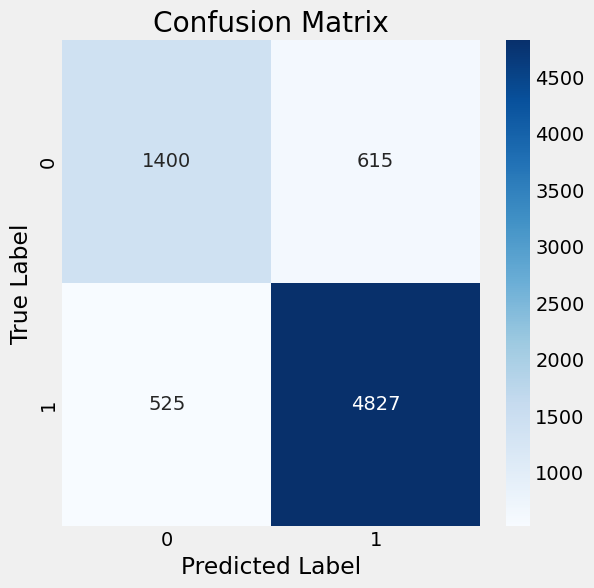

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `train_df` and `test_df` are Spark DataFrames

# Step 1: Train the Random Forest model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='not_fully_paid', numTrees=100)  # Adjust numTrees as needed
model = rf.fit(train_df)

# Step 2: Make predictions on the test set
predictions = model.transform(test_df)

# Step 3: Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="not_fully_paid", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")

# Step 4: Generate classification metrics (precision, recall, F1-score)
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="not_fully_paid", predictionCol="prediction", metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="not_fully_paid", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="not_fully_paid", predictionCol="prediction", metricName="weightedRecall")

f1_score = evaluator_f1.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)

print(f"F1 Score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Step 5: Create a confusion matrix
# Convert predictions and labels to RDD and compute confusion matrix
y_true = predictions.select(col("not_fully_paid")).rdd.flatMap(lambda x: x)
y_pred = predictions.select(col("prediction")).rdd.flatMap(lambda x: x)

cm = y_true.zip(y_pred).map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x, y: x + y).collect()
cm_matrix = np.zeros((2, 2))

for (i, j), count in cm:
    cm_matrix[int(i)][int(j)] = count

# Display the confusion matrix using matplotlib
plt.figure(figsize=(6, 6))
sns.heatmap(cm_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Step 1: Initialize the RandomForestClassifier model
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='not_fully_paid')

# Step 2: Set up a smaller parameter grid for faster hyperparameter tuning
paramGrid = ParamGridBuilder() \
      .addGrid(rf.numTrees, [10, 50]) \
      .addGrid(rf.maxDepth, [5, 10]) \
      .build()

# Step 3: Set up cross-validation with fewer folds
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='not_fully_paid'),
                          numFolds=3)  # Giảm xuống 3-fold cross-validation để giảm thời gian chạy

# Step 4: Train the model using cross-validation
rf_model = crossval.fit(train_df)

# Step 5: Make predictions on the test data
pred_RandomForest = rf_model.transform(test_df)

# Step 6: Evaluate model performance
evaluator = BinaryClassificationEvaluator(labelCol='not_fully_paid')
auc = evaluator.evaluate(pred_RandomForest)

print(f"AUC on test data: {auc:.4f}")


AUC on test data: 0.8090


#Thực nghiệm

In [ ]:
import pandas as pd
from pyspark.sql import SparkSession

# Tạo SparkSession
spark = SparkSession.builder.appName("PandasToSpark").getOrCreate()

# Tạo Pandas DataFrame
pandas_df = pd.DataFrame({
    'revol_bal': [19748],
    'inq_last_6mths': [3],
    'delinq_2yrs': [2],
    'revol_util': [0.567],
    'days_with_cr_line': [  37865],

}, index=[0])

# Chuyển đổi Pandas DataFrame thành Spark DataFrame
spark_df = spark.createDataFrame(pandas_df)

# Hiển thị Spark DataFrame
spark_df.show()


+---------+--------------+-----------+----------+-----------------+
|revol_bal|inq_last_6mths|delinq_2yrs|revol_util|days_with_cr_line|
+---------+--------------+-----------+----------+-----------------+
|    19748|             3|          2|     0.567|            37865|
+---------+--------------+-----------+----------+-----------------+



In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
# Bước 1: Chuẩn bị các đặc trưng
assembler = VectorAssembler(
    inputCols=['revol_bal', 'inq_last_6mths', 'delinq_2yrs', 'revol_util', 'days_with_cr_line'],
    outputCol='features')
# Tạo vector đặc trưng
assembled_df = assembler.transform(spark_df)
# Bước 2: Chuẩn hóa dữ liệu nếu cần (nếu mô hình đã được huấn luyện trên dữ liệu chuẩn hóa)
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)
# Tính toán scaledFeatures
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)


#Logistic

In [ ]:
predictions = lr_model.transform(scaled_df)
# Lấy giá trị dự đoán từ Spark DataFrame
result = predictions.select('prediction').collect()[0][0]
# Kiểm tra kết quả dự đoán và in thông báo
if result == 1:
    print("Trả được khoản vay")
else:
    print("Không trả được khoản vay")

Trả được khoản vay


#Randomforest

In [ ]:
pred_RandomForest = rf_model.transform(scaled_df)
result = pred_RandomForest.select('prediction').collect()[0][0]
if result == 1:
    print("Trả được khoản vay")
else:
    print("Không trả được khoản vay")

Không trả được khoản vay
